In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
AAPL = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_AAPL.csv")
TSLA = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_TSLA.csv")
GOOG = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_MSFT.csv")
AMZN = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_AMZN.csv")

### Preprocesamiento de datos

In [4]:
def Dataset(Data, Date):

  Train_Data = Data['Adj. Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj. Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Modelo basado en Deep Learning

In [5]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [6]:
model = Model()

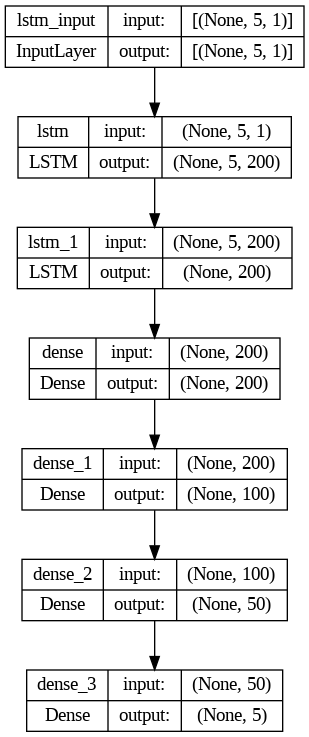

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 548005 (2.09 MB)
Trainable params: 548005 

### Tasa de aprendizaje personalizada

In [9]:
def scheduler(epoch):

  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150)
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)

  return lrate

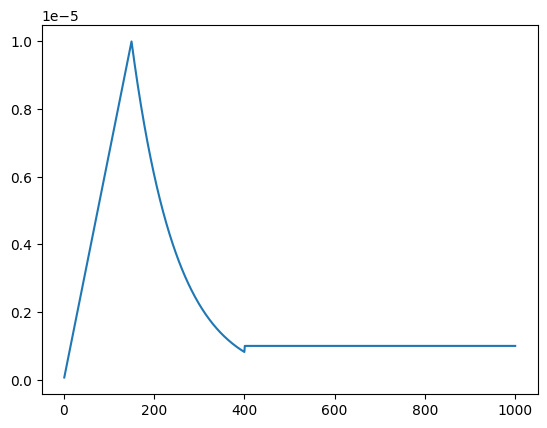

In [10]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [11]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Apple: Base de datos de acciones

In [12]:
AAPL.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [13]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [14]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

###Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [15]:
AAPL_Date = '2020-10-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y = Dataset(AAPL, AAPL_Date)

### Model Fitting

In [16]:
AAPL_Model = Model()

In [17]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [18]:
AAPL_hist = AAPL_Model.fit(AAPL_Train_X, AAPL_Train_Y, epochs = 1000, validation_data = (AAPL_Test_X, AAPL_Test_Y), callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 5s 93ms/step - loss: 2299.0786 - root_mean_squared_error: 47.9487 - val_loss: 15609.7061 - val_root_mean_squared_error: 124.9388 - lr: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 0s 31ms/step - loss: 2299.0645 - root_mean_squared_error: 47.9486 - val_loss: 15609.4404 - val_root_mean_squared_error: 124.9378 - lr: 6.6667e-08
Epoch 3/1000
9/9 [==============================] - 0s 31ms/step - loss: 2299.0166 - root_mean_squared_error: 47.9481 - val_loss: 15608.9277 - val_root_mean_squared_error: 124.9357 - lr: 1.3333e-07
Epoch 4/1000
9/9 [==============================] - 0s 33ms/step - loss: 2298.9385 - root_mean_squared_error: 47.9472 - val_loss: 15608.1367 - val_root_mean_squared_error: 124.9325 - lr: 2.0000e-07
Epoch 5/1000
9/9 [==============================] - 0s 35ms/step - loss: 2298.8257 - root_mean_squared_error: 47.9461 - val_loss: 15607.0840 - val_root_mean_squared_error: 124.9283 - lr: 2.6667e-07
Epoch 6/10

In [19]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

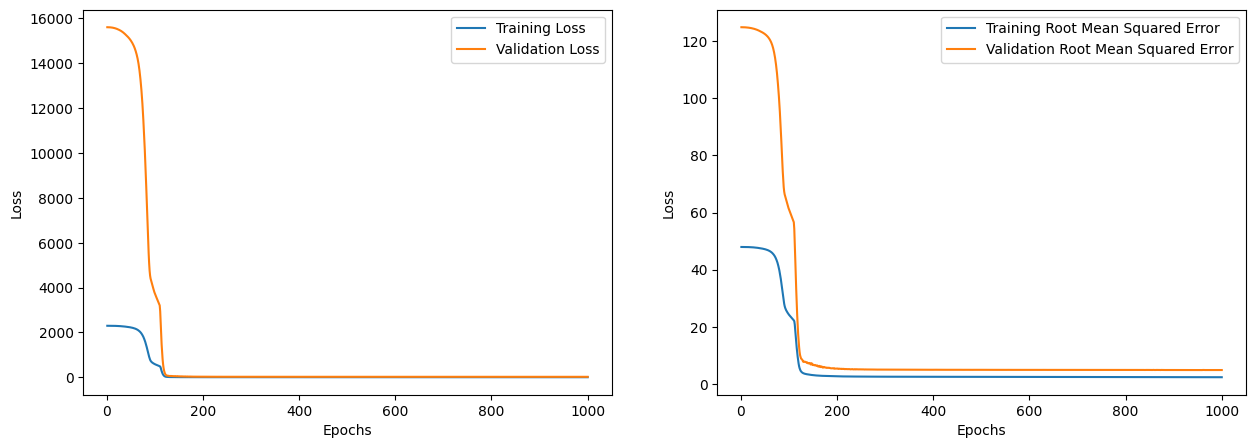

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [21]:
AAPL_prediction = AAPL_Model.predict(AAPL_Test_X)

1/1 [==============================] - 0s 349ms/step


Text(0.5, 1.0, 'APPLE')

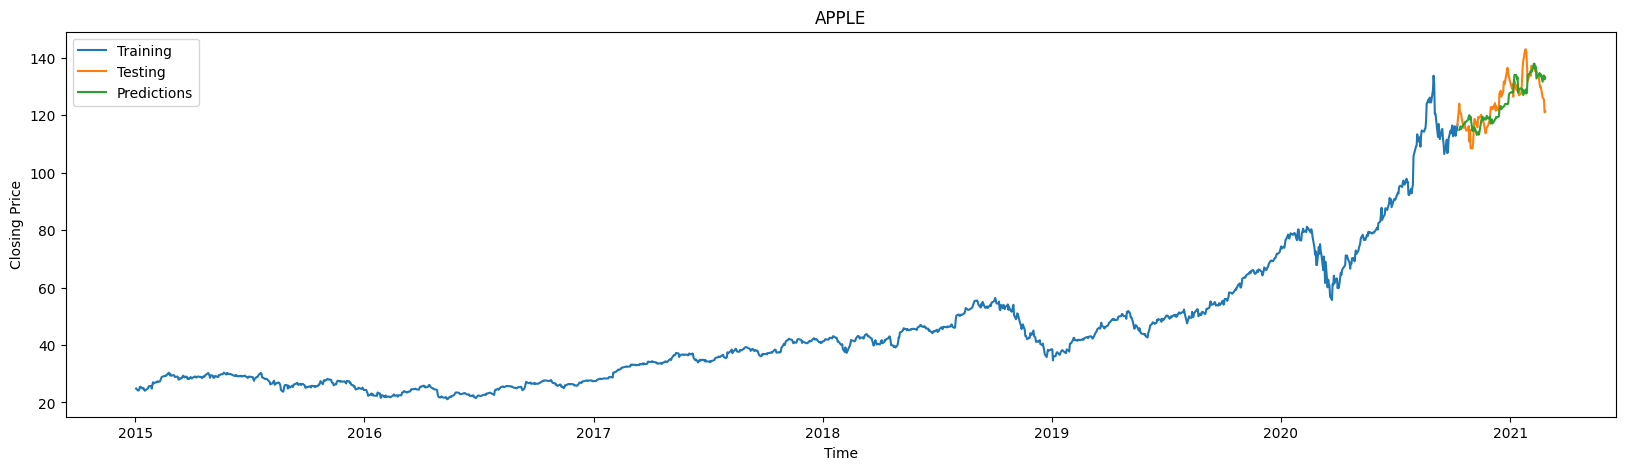

In [86]:
plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < '2020-10-12'], AAPL['Adj. Close'][AAPL['Date'] < '2020-10-12'], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-09'], AAPL['Adj. Close'][AAPL['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-12'], AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.title('APPLE')

In [23]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Test_Y.reshape(-1, 5))/np.abs(AAPL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 4.838943665736656
MAPE: 0.029751668905557867


#Tesla: Base de datos de acciones

In [24]:
TSLA.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,44.57,44.65,42.65,43.86,43.86,23822000.0
1,2015-01-05,42.91,43.30,41.43,42.02,42.02,26842500.0
2,2015-01-06,42.01,42.84,40.84,42.26,42.26,31309500.0
3,2015-01-07,42.67,42.96,41.96,42.19,42.19,14842000.0
4,2015-01-08,42.56,42.76,42.00,42.12,42.12,17212500.0


In [25]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [26]:
# Change Dtype of Date column
TSLA["Date"] = pd.to_datetime(TSLA["Date"])

###Dividir los datos en conjunto de entrenamiento y prueba
    Periodo para partición de entrenamiento: 2015-01-02 - 2020-09-30

    Periodo para partición de testing: 2020-10-01 - 2021-02-26

In [27]:
TSLA_Date = '2020-10-01'
TSLA_Train_X, TSLA_Train_Y, TSLA_Test_X, TSLA_Test_Y = Dataset(TSLA, TSLA_Date)

### Entrenamiento del modelo

In [28]:
TSLA_Model = Model()

In [29]:
TSLA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [30]:
TSLA_hist = TSLA_Model.fit(TSLA_Train_X, TSLA_Train_Y, epochs = 200, validation_data = (TSLA_Test_X, TSLA_Test_Y), callbacks=[callback])

Epoch 1/200
9/9 [==============================] - 3s 81ms/step - loss: 10038.1357 - root_mean_squared_error: 100.1905 - val_loss: 429829.9375 - val_root_mean_squared_error: 655.6142 - lr: 0.0000e+00
Epoch 2/200
9/9 [==============================] - 0s 33ms/step - loss: 10038.0918 - root_mean_squared_error: 100.1903 - val_loss: 429826.9375 - val_root_mean_squared_error: 655.6119 - lr: 6.6667e-08
Epoch 3/200
9/9 [==============================] - 0s 44ms/step - loss: 10037.9658 - root_mean_squared_error: 100.1897 - val_loss: 429820.7500 - val_root_mean_squared_error: 655.6072 - lr: 1.3333e-07
Epoch 4/200
9/9 [==============================] - 0s 45ms/step - loss: 10037.7314 - root_mean_squared_error: 100.1885 - val_loss: 429812.1250 - val_root_mean_squared_error: 655.6006 - lr: 2.0000e-07
Epoch 5/200
9/9 [==============================] - 0s 46ms/step - loss: 10037.4043 - root_mean_squared_error: 100.1869 - val_loss: 429801.2188 - val_root_mean_squared_error: 655.5922 - lr: 2.6667e-07


In [88]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

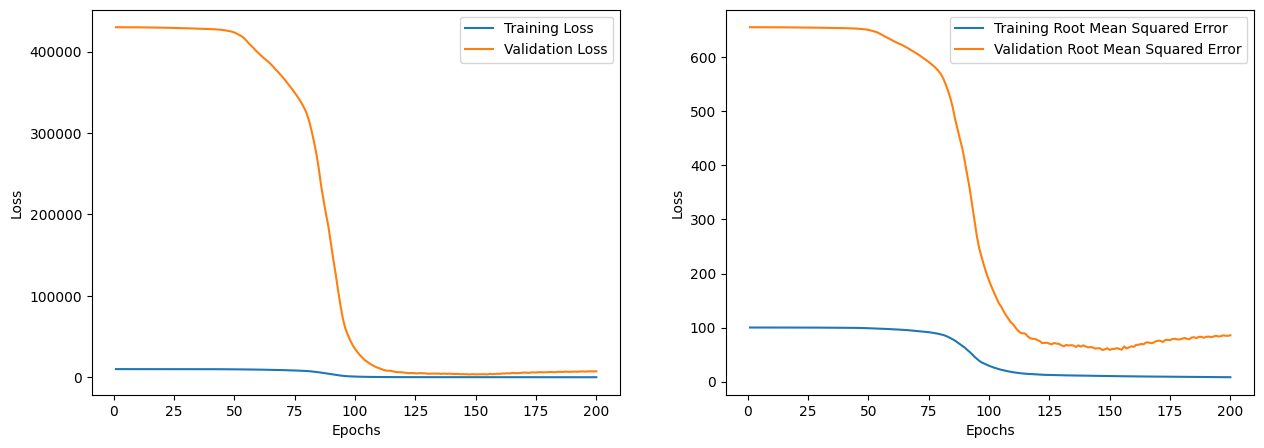

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predecir el precio de cierre de las acciones de Tesla

In [33]:
TSLA_prediction = TSLA_Model.predict(TSLA_Test_X)

1/1 [==============================] - 0s 339ms/step


Text(0.5, 1.0, 'TESLA')

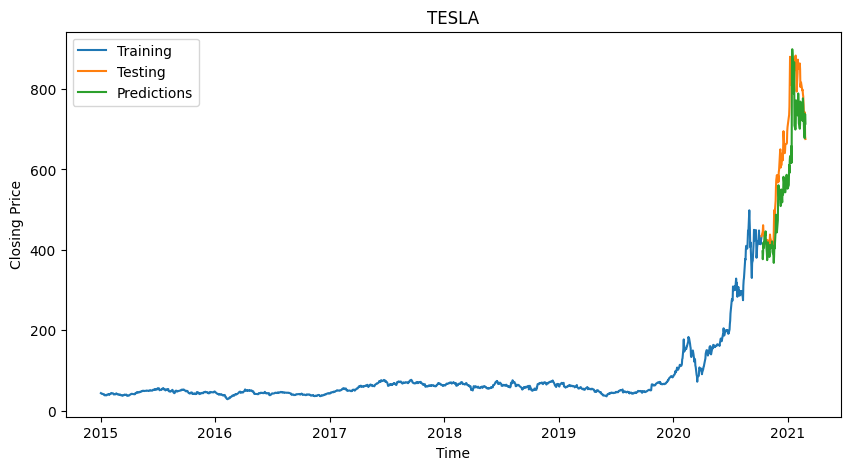

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(TSLA['Date'][TSLA['Date'] < '2020-10-12'], TSLA['Adj. Close'][TSLA['Date'] < '2020-10-12'], label = 'Training')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-09'], TSLA['Adj. Close'][TSLA['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-12'], TSLA_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.title('TESLA')

In [35]:
rmse = math.sqrt(mean_squared_error(TSLA_Test_Y.reshape(-1, 5), TSLA_prediction))
mape = np.mean(np.abs(TSLA_prediction - TSLA_Test_Y.reshape(-1, 5))/np.abs(TSLA_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 85.87293215404469
MAPE: 0.10180644269352547


#Google: Base de datos de acciones

In [36]:
GOOG.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,527.56,529.82,522.67,523.37,523.37,1447563.0
1,2015-01-05,521.83,522.89,511.66,512.46,512.46,2059840.0
2,2015-01-06,513.59,514.76,499.68,500.59,500.59,2899940.0
3,2015-01-07,505.61,505.86,498.28,499.73,499.73,2065054.0
4,2015-01-08,496.63,502.10,489.66,501.30,501.30,3353582.0


In [37]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [38]:
# Change Dtype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

###Dividir los datos en conjunto de entrenamiento y prueba
    Periodo para partición de entrenamiento: 2015-01-02 - 2020-10-30

    Periodo para partición de testing: 2020-11-02 - 2021-02-26

In [39]:
GOOG_Date = '2020-11-01'
GOOG_Train_X, GOOG_Train_Y, GOOG_Test_X, GOOG_Test_Y = Dataset(GOOG, GOOG_Date)

### Entrenamiento del modelo

In [75]:
GOOG_Model = Model()

In [76]:
GOOG_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [77]:
GOOG_hist = GOOG_Model.fit(GOOG_Train_X, GOOG_Train_Y, epochs = 1000, validation_data = (GOOG_Test_X, GOOG_Test_Y), callbacks = [callback])

Epoch 1/1000
10/10 [==============================] - 5s 75ms/step - loss: 1045004.5000 - root_mean_squared_error: 1022.2546 - val_loss: 3425361.0000 - val_root_mean_squared_error: 1850.7731 - lr: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 0s 30ms/step - loss: 1044978.8750 - root_mean_squared_error: 1022.2421 - val_loss: 3425159.2500 - val_root_mean_squared_error: 1850.7186 - lr: 6.6667e-08
Epoch 3/1000
10/10 [==============================] - 0s 33ms/step - loss: 1044893.0625 - root_mean_squared_error: 1022.2001 - val_loss: 3424741.0000 - val_root_mean_squared_error: 1850.6056 - lr: 1.3333e-07
Epoch 4/1000
10/10 [==============================] - 0s 34ms/step - loss: 1044752.0000 - root_mean_squared_error: 1022.1312 - val_loss: 3424139.2500 - val_root_mean_squared_error: 1850.4430 - lr: 2.0000e-07
Epoch 5/1000
10/10 [==============================] - 0s 47ms/step - loss: 1044557.2500 - root_mean_squared_error: 1022.0359 - val_loss: 3423373.2500 - val_root_mean_sq

In [78]:
history_dict = GOOG_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

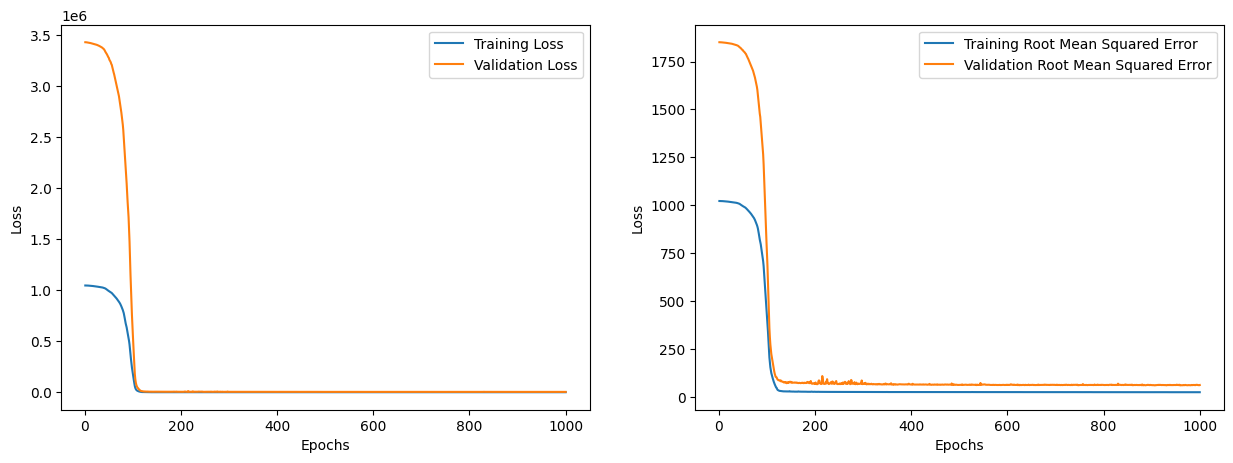

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predecir el precio de cierre de las acciones de Google

In [80]:
GOOG_prediction = GOOG_Model.predict(GOOG_Test_X)

1/1 [==============================] - 0s 463ms/step


Text(0.5, 1.0, 'GOOGLE')

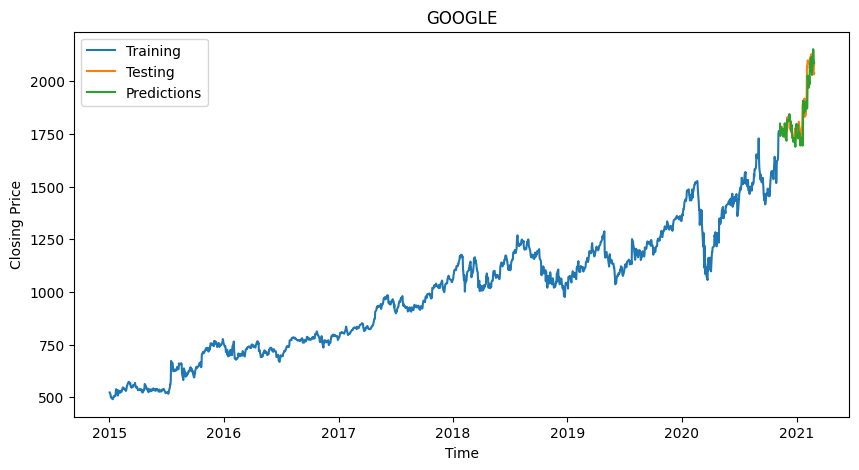

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(GOOG['Date'][GOOG['Date'] < '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] < '2020-11-07'], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.title('GOOGLE')

In [48]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Y.reshape(-1, 5), GOOG_prediction))
mape = np.mean(np.abs(GOOG_prediction - GOOG_Test_Y.reshape(-1, 5))/np.abs(GOOG_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 71.26884841865923
MAPE: 0.028184836186723353


#Microsoft: Base de datos de acciones

In [49]:
MSFT.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,46.66,47.42,46.54,46.76,41.44,27913900.0
1,2015-01-05,46.37,46.73,46.25,46.33,41.06,39673900.0
2,2015-01-06,46.38,46.75,45.54,45.65,40.46,36447900.0
3,2015-01-07,45.98,46.46,45.49,46.23,40.97,29114100.0
4,2015-01-08,46.75,47.75,46.72,47.59,42.18,29645200.0


In [50]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [51]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

###Dividir los datos en conjunto de entrenamiento y prueba
    Periodo para partición de entrenamiento: 2015-01-02 - 2020-09-30

    Periodo para partición de testing: 2020-10-01 - 2021-02-26

In [52]:
MSFT_Date = '2020-10-01'
MSFT_Train_X, MSFT_Train_Y, MSFT_Test_X, MSFT_Test_Y = Dataset(MSFT, MSFT_Date)

### Entrenamiento del modelo

In [53]:
MSFT_Model = Model()

In [54]:
MSFT_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [55]:
MSFT_hist = MSFT_Model.fit(MSFT_Train_X, MSFT_Train_Y, epochs = 1000, validation_data = (MSFT_Test_X, MSFT_Test_Y), callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 6s 150ms/step - loss: 10509.7031 - root_mean_squared_error: 102.5168 - val_loss: 48443.7656 - val_root_mean_squared_error: 220.0994 - lr: 0.0000e+00
Epoch 2/1000
9/9 [==============================] - 1s 59ms/step - loss: 10509.6201 - root_mean_squared_error: 102.5164 - val_loss: 48442.7773 - val_root_mean_squared_error: 220.0972 - lr: 6.6667e-08
Epoch 3/1000
9/9 [==============================] - 1s 80ms/step - loss: 10509.3418 - root_mean_squared_error: 102.5151 - val_loss: 48440.8047 - val_root_mean_squared_error: 220.0927 - lr: 1.3333e-07
Epoch 4/1000
9/9 [==============================] - 1s 76ms/step - loss: 10508.8945 - root_mean_squared_error: 102.5129 - val_loss: 48437.7500 - val_root_mean_squared_error: 220.0858 - lr: 2.0000e-07
Epoch 5/1000
9/9 [==============================] - 1s 77ms/step - loss: 10508.2266 - root_mean_squared_error: 102.5096 - val_loss: 48433.8164 - val_root_mean_squared_error: 220.0768 - lr: 2.6667e-07

In [56]:
history_dict = MSFT_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

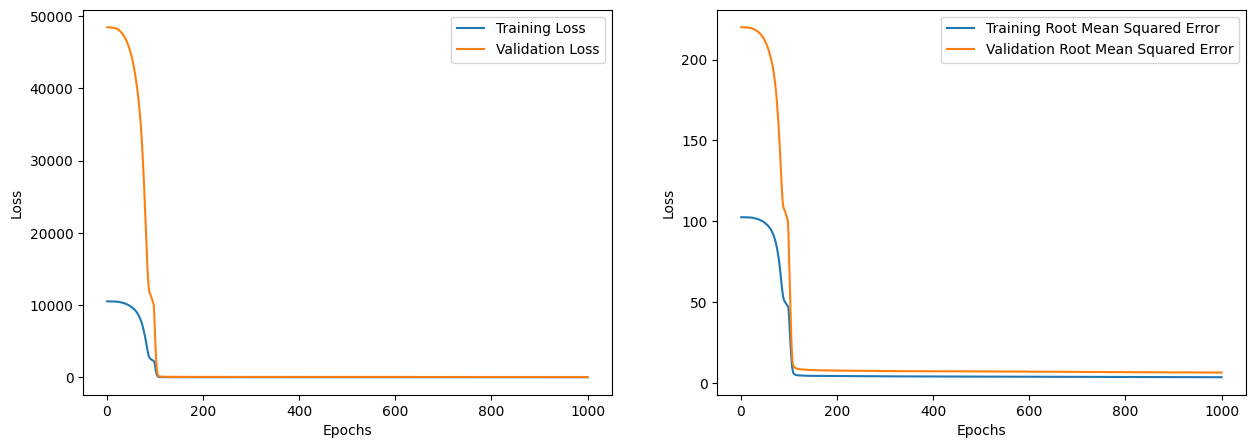

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predecir el precio de cierre de las acciones de Microsoft

In [58]:
MSFT_prediction = MSFT_Model.predict(MSFT_Test_X)

1/1 [==============================] - 0s 337ms/step


Text(0.5, 1.0, 'MICROSOFT')

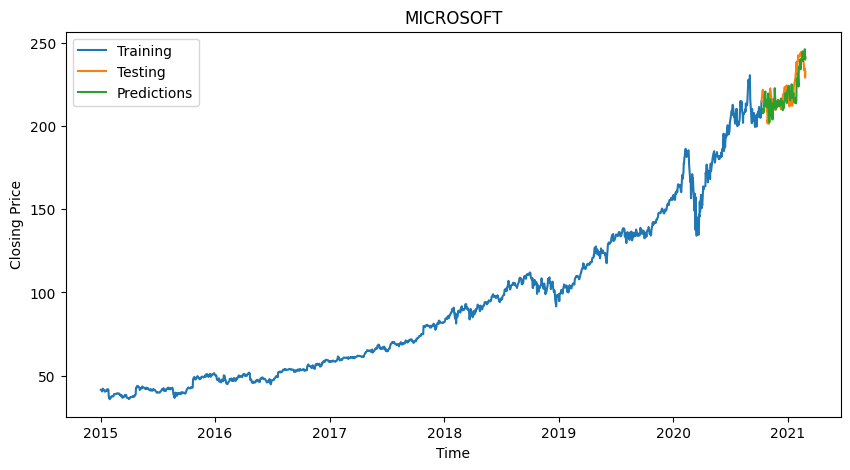

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(MSFT['Date'][MSFT['Date'] < '2020-10-12'], MSFT['Adj. Close'][MSFT['Date'] < '2020-10-12'], label = 'Training')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-09'], MSFT['Adj. Close'][MSFT['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-12'], MSFT_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.title('MICROSOFT')

In [60]:
rmse = math.sqrt(mean_squared_error(MSFT_Test_Y.reshape(-1, 5), MSFT_prediction))
mape = np.mean(np.abs(MSFT_prediction - MSFT_Test_Y.reshape(-1, 5))/np.abs(MSFT_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 6.39327490440265
MAPE: 0.02105151965113411


#Amazon: Base de datos de acciones

In [61]:
AMZN.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,312.58,314.75,306.96,308.52,308.52,2783200.0
1,2015-01-05,307.01,308.38,300.85,302.19,302.19,2774200.0
2,2015-01-06,302.24,303.00,292.38,295.29,295.29,3519000.0
3,2015-01-07,297.50,301.28,295.33,298.42,298.42,2640300.0
4,2015-01-08,300.32,303.14,296.11,300.46,300.46,3088400.0


In [62]:
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [63]:
# Change Dtype of Date column
AMZN["Date"] = pd.to_datetime(AMZN["Date"])

###Dividir los datos en conjunto de entrenamiento y prueba
    Periodo para partición de entrenamiento: 2015-01-02 - 2020-10-30

    Periodo para partición de testing: 2020-11-02 - 2021-02-26

In [64]:
AMZN_Date = '2020-11-01'
AMZN_Train_X, AMZN_Train_Y, AMZN_Test_X, AMZN_Test_Y = Dataset(AMZN, AMZN_Date)

### Entrenamiento del modelo

In [65]:
AMZN_Model = Model()

In [66]:
AMZN_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [67]:
AMZN_hist = AMZN_Model.fit(AMZN_Train_X, AMZN_Train_Y, epochs = 200, validation_data = (AMZN_Test_X, AMZN_Test_Y), callbacks=[callback])

Epoch 1/200
10/10 [==============================] - 4s 84ms/step - loss: 2266199.0000 - root_mean_squared_error: 1505.3900 - val_loss: 10126014.0000 - val_root_mean_squared_error: 3182.1399 - lr: 0.0000e+00
Epoch 2/200
10/10 [==============================] - 0s 32ms/step - loss: 2266185.5000 - root_mean_squared_error: 1505.3854 - val_loss: 10125833.0000 - val_root_mean_squared_error: 3182.1113 - lr: 6.6667e-08
Epoch 3/200
10/10 [==============================] - 0s 35ms/step - loss: 2266135.2500 - root_mean_squared_error: 1505.3688 - val_loss: 10125487.0000 - val_root_mean_squared_error: 3182.0571 - lr: 1.3333e-07
Epoch 4/200
10/10 [==============================] - 0s 34ms/step - loss: 2266051.0000 - root_mean_squared_error: 1505.3409 - val_loss: 10124946.0000 - val_root_mean_squared_error: 3181.9722 - lr: 2.0000e-07
Epoch 5/200
10/10 [==============================] - 0s 34ms/step - loss: 2265932.2500 - root_mean_squared_error: 1505.3014 - val_loss: 10124230.0000 - val_root_mean_sq

In [68]:
history_dict = AMZN_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

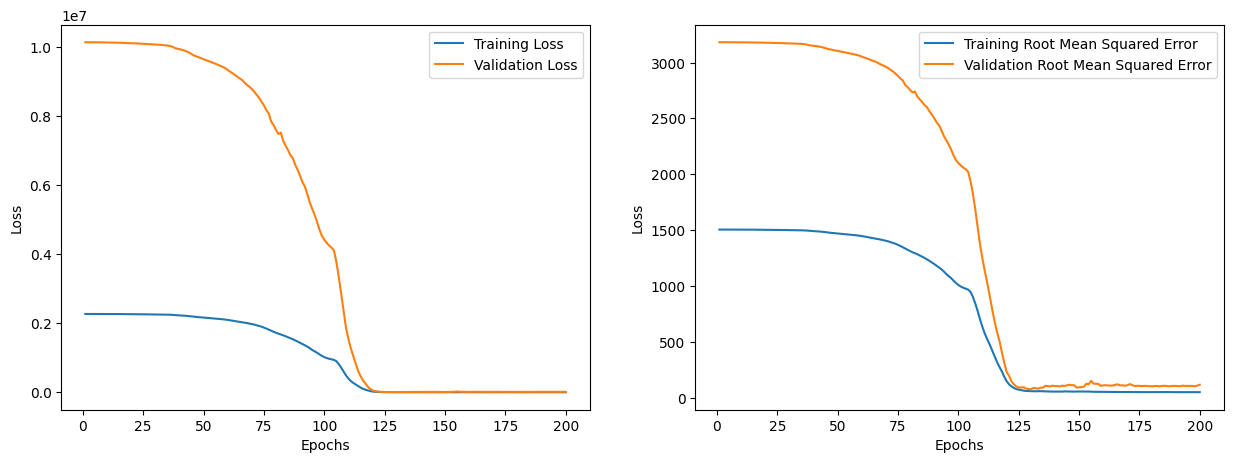

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predecir el precio de cierre de las acciones de Amazon

In [70]:
AMZN_prediction = AMZN_Model.predict(AMZN_Test_X)

1/1 [==============================] - 0s 312ms/step


Text(0.5, 1.0, 'AMAZON')

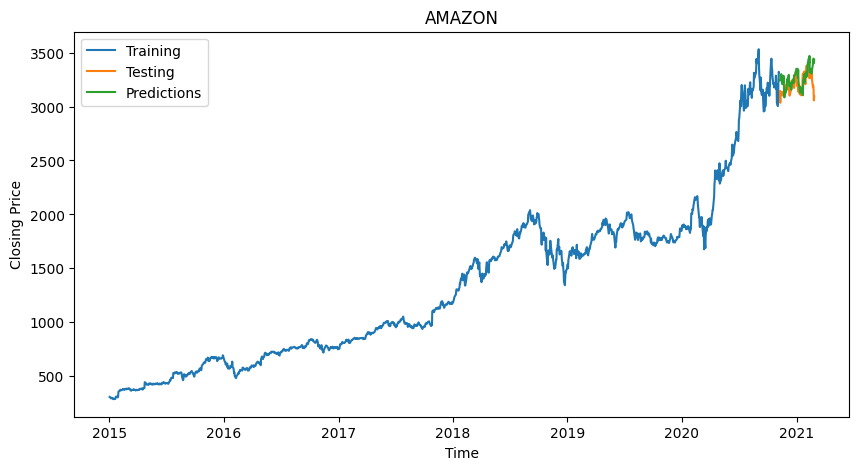

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(AMZN['Date'][AMZN['Date'] < '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] < '2020-11-07'], label = 'Training')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
plt.title('AMAZON')

In [72]:
rmse = math.sqrt(mean_squared_error(AMZN_Test_Y.reshape(-1, 5), AMZN_prediction))
mape = np.mean(np.abs(AMZN_prediction - AMZN_Test_Y.reshape(-1, 5))/np.abs(AMZN_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 115.9754300689226
MAPE: 0.027080047994664066
